# Standardization

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20, 9)
pd.set_option('display.max_columns', 500)

In [2]:
transactions = pd.read_csv('onlinefraud_with_features.csv')
transactions.head()

,step,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,has_debt,debt,origins_count,min_amount,max_amount,std_amount,median_amount,mean_amount,min_oldbalanceOrg,max_oldbalanceOrg,std_oldbalanceOrg,median_oldbalanceOrg,mean_oldbalanceOrg,min_newbalanceOrig,max_newbalanceOrig,std_newbalanceOrig,median_newbalanceOrig,mean_newbalanceOrig,min_oldbalanceDest,max_oldbalanceDest,std_oldbalanceDest,median_oldbalanceDest,mean_oldbalanceDest,min_newbalanceDest,max_newbalanceDest,std_newbalanceDest,median_newbalanceDest,mean_newbalanceDest,min_step,max_step,std_step,median_step,mean_step,min_has_debt,max_has_debt,std_has_debt,median_has_debt,mean_has_debt,nameDestFirstLetter,amount_has_cents,amount_has_units,amount_has_tens,amount_has_hundreds,amount_is_equal_to_balance,type_code,type=PAYMENT,type=TRANSFER,type=CASH_IN,type=CASH_OUT,nameDestFirstLetter_code,nameDestFirstLetter=M
0,1,9839.64,170136.00,160296.36,M1979787155,0.00,0.00,0,False,-0.00,1,9839.64,9839.64,0.000000,9839.640,9839.640000,170136.0,170136.00,0.000000e+00,170136.0,1.701360e+05,160296.36,160296.36,0.000000e+00,160296.36,1.602964e+05,0.0,0.00,0.000000e+00,0.00,0.000000e+00,0.0,0.00,0.000000e+00,0.00,0.000000e+00,1,1,0.000000,1.0,1.000000,False,False,0.000000,0.0,0.000000,M,True,True,True,True,False,3,True,False,False,False,1,True
1,1,1864.28,21249.00,19384.72,M2044282225,0.00,0.00,0,False,-0.00,1,1864.28,1864.28,0.000000,1864.280,1864.280000,21249.0,21249.00,0.000000e+00,21249.0,2.124900e+04,19384.72,19384.72,0.000000e+00,19384.72,1.938472e+04,0.0,0.00,0.000000e+00,0.00,0.000000e+00,0.0,0.00,0.000000e+00,0.00,0.000000e+00,1,1,0.000000,1.0,1.000000,False,False,0.000000,0.0,0.000000,M,True,True,True,True,False,3,True,False,False,False,1,True
2,1,181.00,181.00,0.00,C553264065,0.00,0.00,1,False,0.00,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,False,True,True,True,True,4,False,True,False,False,0,False
3,6,109985.65,41851.00,0.00,C553264065,0.00,109985.65,0,True,68134.65,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,True,True,True,True,False,4,False,True,False,False,0,False
4,7,10256.20,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,False,-0.00,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,True,True,True,True,False,0,False,False,True,False,0,False


In [3]:
transactions['nameDestFirstLetterIsM'] = transactions['nameDestFirstLetter'] == 'M'
transactions.drop(columns=['nameDestFirstLetter'], inplace=True)

## Split data into train, test and validation sets

In [4]:
train_size = 0.5
test_size = 0.2
validation_size = 0.3
assert train_size + test_size + validation_size == 1

target_column = 'isFraud'
X = transactions.drop(columns=target_column)
y = transactions[target_column]

random_state = 42

datasets = {}

### Common split

In this case we just split data with respect to labels to keep the same positive and negative classes balance in sets.

In [5]:
def add_common_splitted_data(X, y, key='common'):
    X_train, X_remaining, y_train, y_remaining = train_test_split(
        X,
        y,
        train_size=train_size,
        random_state=random_state,
        stratify=y
    )

    X_validation, X_test, y_validation, y_test = train_test_split(
        X_remaining,
        y_remaining,
        test_size=test_size / (test_size + validation_size),
        stratify=y_remaining
    )

    datasets[key] = {
        'X': {
            'train': X_train,
            'test': X_test,
            'validation': X_validation
        },
        'y': {
            'train': y_train,
            'test': y_test,
            'validation': y_validation
        }
    }
add_common_splitted_data(X, y)

### Group split

We use this split to keep all data with the same destination name in one set, to prevent data leak.

In [6]:
round(y.mean(), 5)

0.00129

In [7]:
round(transactions.groupby('nameDest')[target_column].mean().apply(lambda value: int(value * 2) - int(value)).mean(), 5)

0.00126

As we can see, if we group data by nameDest and define class label as label of the major part of the group, we will receive the same balance of classes.

In [8]:
def train_test_split_group(*arrays, **kwargs):
    group_name = kwargs.get('group_name')
    if group_name is None:
        return train_test_split_group(*arrays, **kwargs)
    else:
        del kwargs['group_name']

    X = arrays[0]
    Y = arrays[1]
    data = pd.concat([X, Y], axis=1)
    # define label of group as average of labels of this group, rounded to integer, according to math rules (<0.5 -> 0, >=0.5 -> 1)
    grouped_data = data.groupby(group_name)[target_column].mean().apply(lambda value: int(value * 2) - int(value)).reset_index()
    x = grouped_data[[group_name]]
    y = grouped_data[target_column]
    groups_train, _, _, _ = train_test_split(
        x,
        y,
        stratify=y,
        **kwargs
    )
    train_index = X[group_name].isin(groups_train[group_name].tolist())
    test_index = ~train_index

    X_train = X[train_index]
    y_train = Y[train_index]

    X_test = X[test_index]
    y_test = Y[test_index]

    return X_train, X_test, y_train, y_test

In [9]:
def add_group_splitted_data(X, y, key='group'):
    X_train, X_remaining, y_train, y_remaining = train_test_split_group(X, y, group_name='nameDest', train_size=train_size)
    X_validation, X_test, y_validation, y_test = train_test_split_group(
        X_remaining,
        y_remaining,
        group_name='nameDest',
        test_size=test_size / (test_size + validation_size)
    )

    datasets[key] = {
        'X': {
            'train': X_train,
            'test': X_test,
            'validation': X_validation
        },
        'y': {
            'train': y_train,
            'test': y_test,
            'validation': y_validation
        }
    }
    return X_train, X_test, X_validation, y_train, y_test, y_validation

In [10]:
X_train, X_test, X_validation, y_train, y_test, y_validation = add_group_splitted_data(X, y)

In [11]:
y_train_mean = round(y_train.mean(), 5)
y_test_mean = round(y_test.mean(), 5)
print(f'{y_train_mean=}\t{y_test_mean=}')

y_train_mean=0.0013	y_test_mean=0.00131


In [12]:
pd.merge(
    left=X_train,
    right=X_test,
    on='nameDest'
)

,step_x,amount_x,oldbalanceOrg_x,newbalanceOrig_x,nameDest,oldbalanceDest_x,newbalanceDest_x,has_debt_x,debt_x,origins_count_x,min_amount_x,max_amount_x,std_amount_x,median_amount_x,mean_amount_x,min_oldbalanceOrg_x,max_oldbalanceOrg_x,std_oldbalanceOrg_x,median_oldbalanceOrg_x,mean_oldbalanceOrg_x,min_newbalanceOrig_x,max_newbalanceOrig_x,std_newbalanceOrig_x,median_newbalanceOrig_x,mean_newbalanceOrig_x,min_oldbalanceDest_x,max_oldbalanceDest_x,std_oldbalanceDest_x,median_oldbalanceDest_x,mean_oldbalanceDest_x,min_newbalanceDest_x,max_newbalanceDest_x,std_newbalanceDest_x,median_newbalanceDest_x,mean_newbalanceDest_x,min_step_x,max_step_x,std_step_x,median_step_x,mean_step_x,min_has_debt_x,max_has_debt_x,std_has_debt_x,median_has_debt_x,mean_has_debt_x,amount_has_cents_x,amount_has_units_x,amount_has_tens_x,amount_has_hundreds_x,amount_is_equal_to_balance_x,type_code_x,type=PAYMENT_x,type=TRANSFER_x,type=CASH_IN_x,type=CASH_OUT_x,nameDestFirstLetter_code_x,nameDestFirstLetter=M_x,nameDestFirstLetterIsM_x,step_y,amount_y,oldbalanceOrg_y,newbalanceOrig_y,oldbalanceDest_y,newbalanceDest_y,has_debt_y,debt_y,origins_count_y,min_amount_y,max_amount_y,std_amount_y,median_amount_y,mean_amount_y,min_oldbalanceOrg_y,max_oldbalanceOrg_y,std_oldbalanceOrg_y,median_oldbalanceOrg_y,mean_oldbalanceOrg_y,min_newbalanceOrig_y,max_newbalanceOrig_y,std_newbalanceOrig_y,median_newbalanceOrig_y,mean_newbalanceOrig_y,min_oldbalanceDest_y,max_oldbalanceDest_y,std_oldbalanceDest_y,median_oldbalanceDest_y,mean_oldbalanceDest_y,min_newbalanceDest_y,max_newbalanceDest_y,std_newbalanceDest_y,median_newbalanceDest_y,mean_newbalanceDest_y,min_step_y,max_step_y,std_step_y,median_step_y,mean_step_y,min_has_debt_y,max_has_debt_y,std_has_debt_y,median_has_debt_y,mean_has_debt_y,amount_has_cents_y,amount_has_units_y,amount_has_tens_y,amount_has_hundreds_y,amount_is_equal_to_balance_y,type_code_y,type=PAYMENT_y,type=TRANSFER_y,type=CASH_IN_y,type=CASH_OUT_y,nameDestFirstLetter_code_y,nameDestFirstLetter=M_y,nameDestFirstLetterIsM_y


Our split allowed us to keep the same balance of classes in sets, and also keep all transactions of one recipient in one set to avoid data leek

### Split only types of interest

Not each type of transaction has fraud transactions. Let's simplify data for model and remove types of transactions which doesn't have fraud.

In [13]:
transactions_of_interest = transactions[transactions['type=TRANSFER'] | transactions['type=CASH_OUT']]
X = transactions_of_interest.drop(columns=target_column)
y = transactions_of_interest[target_column]
add_common_splitted_data(X, y, 'common_main_types')
_ = add_group_splitted_data(X, y, 'group_main_types')

In [14]:
datasets.keys()

dict_keys(['common', 'group', 'common_main_types', 'group_main_types'])

In [15]:
for dataset_name, dataset in datasets.items():
    print(dataset_name)
    for set_type in ['train', 'test', 'validation']:
        print()
        print(set_type)
        print(f"{dataset['X'][set_type].shape=}\t{dataset['y'][set_type].shape=}")
    print('\n')

common

train
dataset['X'][set_type].shape=(3181310, 58)	dataset['y'][set_type].shape=(3181310,)

test
dataset['X'][set_type].shape=(1272524, 58)	dataset['y'][set_type].shape=(1272524,)

validation
dataset['X'][set_type].shape=(1908786, 58)	dataset['y'][set_type].shape=(1908786,)


group

train
dataset['X'][set_type].shape=(3182425, 58)	dataset['y'][set_type].shape=(3182425,)

test
dataset['X'][set_type].shape=(1271213, 58)	dataset['y'][set_type].shape=(1271213,)

validation
dataset['X'][set_type].shape=(1908982, 58)	dataset['y'][set_type].shape=(1908982,)


common_main_types

train
dataset['X'][set_type].shape=(1385204, 58)	dataset['y'][set_type].shape=(1385204,)

test
dataset['X'][set_type].shape=(554082, 58)	dataset['y'][set_type].shape=(554082,)

validation
dataset['X'][set_type].shape=(831123, 58)	dataset['y'][set_type].shape=(831123,)


group_main_types

train
dataset['X'][set_type].shape=(1384082, 58)	dataset['y'][set_type].shape=(1384082,)

test
dataset['X'][set_type].shape=(55

### Standardization

In [16]:
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

columns_to_drop = ['nameDest']
for dataset_name, dataset in tqdm(datasets.items()):
    X = dataset['X']
    y = dataset['y']

    scaler = StandardScaler()

    columns = X['train'].drop(columns=columns_to_drop).columns
    train = scaler.fit_transform(X['train'].drop(columns=columns_to_drop))
    test = scaler.transform(X['test'].drop(columns=columns_to_drop))
    validation = scaler.transform(X['validation'].drop(columns=columns_to_drop))

    X['train'] = pd.DataFrame(train, columns=columns)
    X['test'] = pd.DataFrame(test, columns=columns)
    X['validation'] = pd.DataFrame(validation, columns=columns)

    del train
    del test
    del validation

    for key, value in tqdm(X.items()):
        dir_name = 'data'
        if not os.path.isdir(dir_name):
            os.mkdir(dir_name)
        value.to_csv(f'./{dir_name}/x_{dataset_name}_{key}.csv', index=False)
        y[key].to_csv(f'./{dir_name}/y_{dataset_name}_{key}.csv', index=False)

100%|██████████| 4/4 [17:44<00:00, 266.08s/it]


In [17]:
data = datasets['group_main_types']
X = data['X']
y = data['y']

X_train, X_test, X_validation = X['train'], X['test'], X['validation']
y_train, y_test, y_validation = y['train'], y['test'], y['validation']

del datasets
del transactions

# Dimensionality reduction

Let's reduce number of dimensions to achieve better results

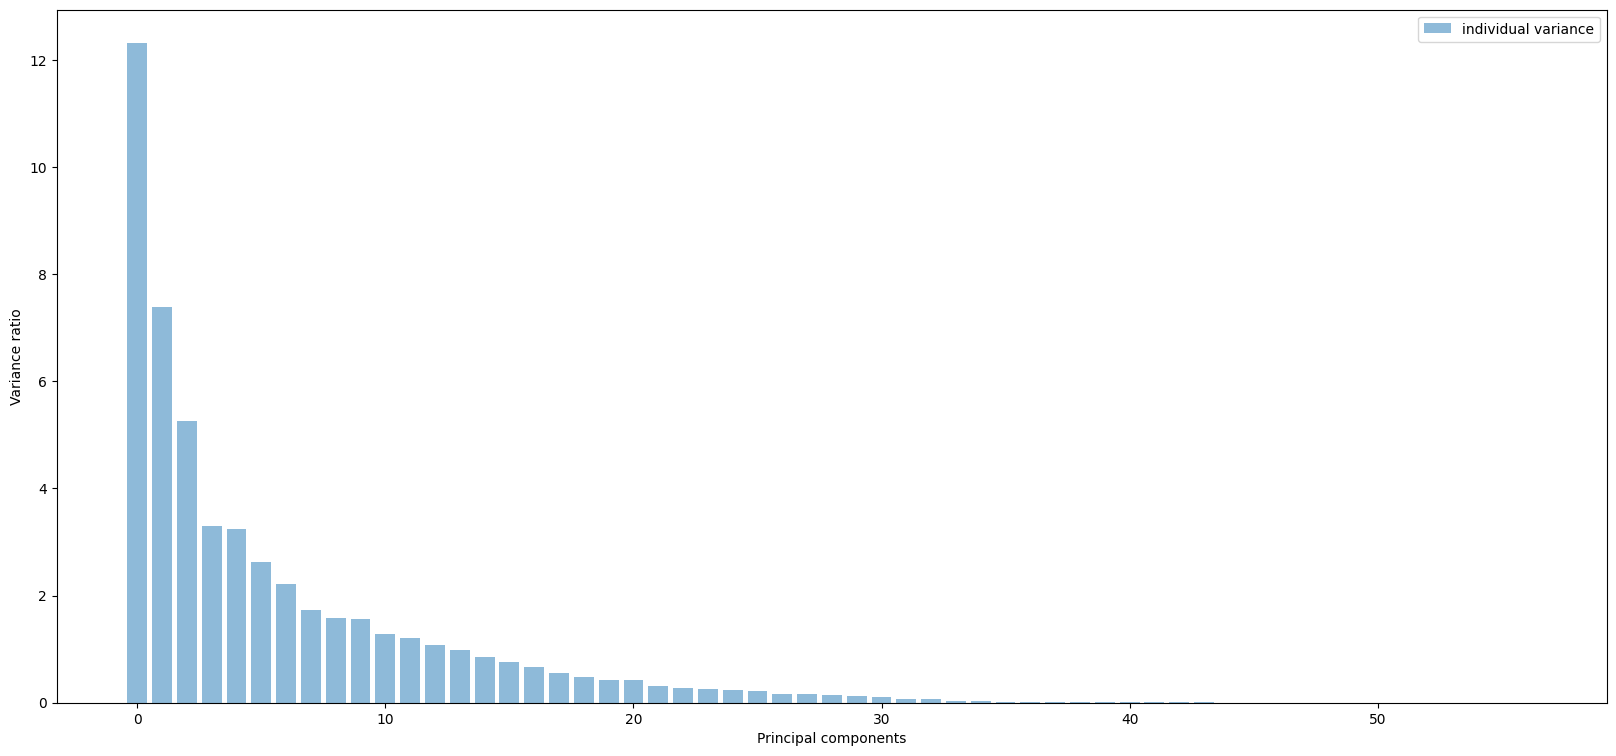

In [21]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(X_validation)
pca_variance = pca.explained_variance_

plt.bar(range(X_validation.shape[1]), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

As we can see, about 20 features are the most informative according to PCA. But we want to keep data easy to interpret, so let's choose other methods for dimensionality reduciton.